In [ ]:
import torch
import json
import torchvision
import shutil
import os
import ultralytics
from matplotlib import pyplot as plt, patches

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [3]:
CLASS_MAP = {
    4: 0,
    5: 1,
}

In [4]:
yolo = ultralytics.YOLO("last.pt" if os.path.exists("last.pt") else "yolo11n.pt")
if os.path.exists("last.pt"):
    yolo.resume = True

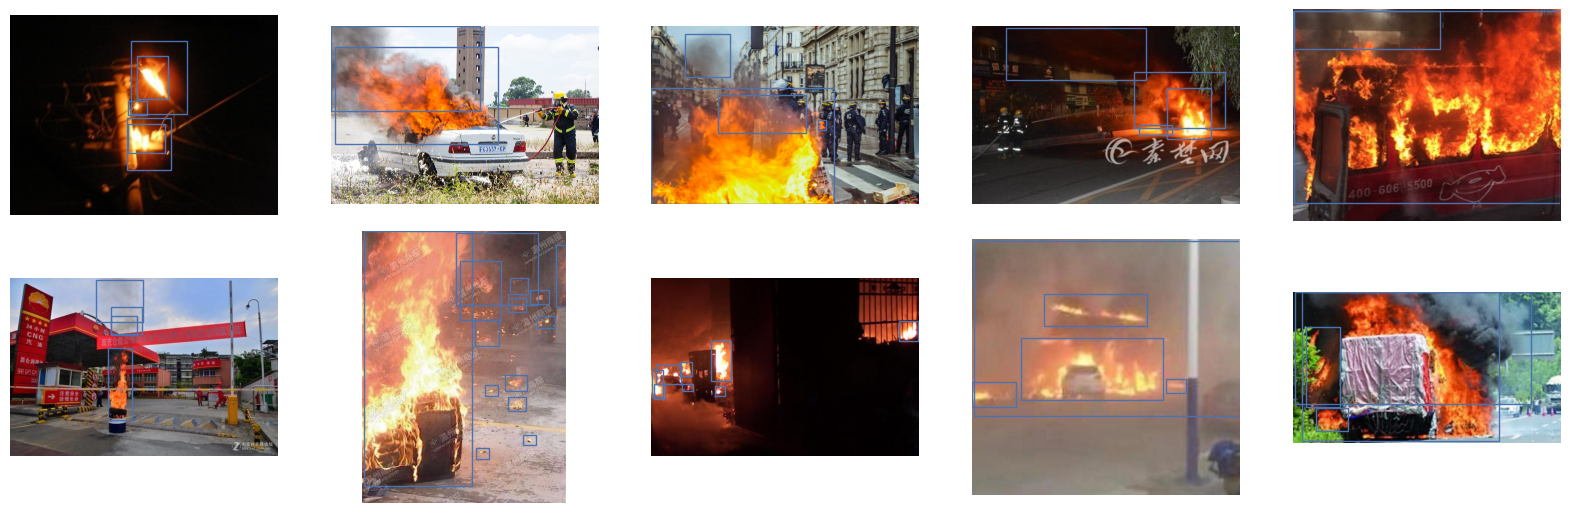

In [61]:
with open('./data/475_fire_train/annotations/instances_default.json', 'r') as f:
    data = json.load(f)

    row = 1

    plt.figure(figsize=(20, 12))

    for index, image_data in enumerate(data['images'][0:10]):
        if index % 5 == 0:
            row += 1

        image = torchvision.io.read_image(
            os.path.join('data', '475_fire_train', 'images', image_data['file_name'])
        )
        image = image.permute(1, 2, 0)

        ax = plt.subplot(row, 5, index + 1)

        annotations = [a for a in data['annotations'] if a['image_id'] == image_data['id'] and a['category_id'] in (4, 5)]

        for annotation in annotations:
            x, y, w, h = annotation['bbox']
            patch = patches.Rectangle(
                (x, y), w, h,
                linewidth=1,
                edgecolor='b',
                facecolor='none',
            )
            ax.add_patch(patch)

        ax.axis('off')
        ax.imshow(image)
        

    plt.show()  

In [6]:
def convert_data(mode, base_dir):
    shutil.copytree(
        os.path.join('data', base_dir, 'images', mode),
        os.path.join('converted_data', 'images', mode)
    )

    if not os.path.exists(os.path.join('converted_data', 'labels', mode)):   
        os.makedirs(os.path.join('converted_data', 'labels', mode))

    with open(os.path.join('data', base_dir, 'annotations', 'instances_default.json'), 'r') as f:
        data = json.load(f)

        image_id_to_image = { image['id']: image for image in data['images'] }

        result = dict()
        class_dist = dict()

        for annotation in data['annotations']:
            # we are interested only in fire and smoke categories from the dataset
            if annotation['category_id'] != 4 and annotation['category_id'] != 5:
                continue
            
            image_id = annotation['image_id']
            image = image_id_to_image[image_id]
            image_w, image_h = image['width'], image['height']
            x, y, w, h = annotation['bbox']

            x = (x + w / 2) / image_w
            y = (y + h / 2) / image_h
            w = w / image_w
            h = h / image_h

            normalized_bbox = [x, y, w, h]

            class_id = CLASS_MAP[annotation['category_id']]

            result.setdefault(image_id, []).append([class_id, *normalized_bbox])

            class_dist.setdefault(class_id, 0)
            class_dist[class_id] += 1

        print(f"Class dist: {class_dist}")

        for image_id, annotations in result.items():
            image_name = image_id_to_image[image_id]['file_name']
            image_name = image_name.split('/')[1]
            image_name = image_name.split('.')[0]

            with open(os.path.join('converted_data', 'labels', mode, f"{image_name}.txt"), 'a') as f:
                for annotation in annotations:
                    f.write(' '.join(list(map(str, annotation)) + ['\n']))

shutil.rmtree('converted_data')
convert_data('train', '475_fire_train')
convert_data('val', '474_fire_val')


Class dist: {1: 2914, 0: 1527}
Class dist: {1: 761, 0: 524}


In [ ]:
train_results = yolo.train(
    data='data.yaml',
    epochs=30,
    batch=8,
    device=device,
)

New https://pypi.org/project/ultralytics/8.3.113 available 😃 Update with 'pip install -U ultralytics'
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=data.yaml, epochs=30, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train46, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wid

train: Scanning /home/stepan/Private/fsd_project/converted_data/labels/train... 1142 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1142/1142 [00:00<00:00, 2889.26it/s]


train: New cache created: /home/stepan/Private/fsd_project/converted_data/labels/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 479.0±299.3 MB/s, size: 17.6 KB)


val: Scanning /home/stepan/Private/fsd_project/converted_data/labels/val... 308 images, 0 backgrounds, 0 corrupt: 100%|██████████| 308/308 [00:00<00:00, 1146.89it/s]

val: New cache created: /home/stepan/Private/fsd_project/converted_data/labels/val.cache


Plotting labels to /home/stepan/Private/fsd_project/runs/detect/train46/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/stepan/Private/fsd_project/runs/detect/train46
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      1.23G      1.619      2.446      1.554         57        640: 100%|██████████| 143/143 [00:13<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  8.84it/s]

                   all        308       1285      0.447      0.327      0.306      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      1.56G      1.657      1.983      1.553         32        640: 100%|██████████| 143/143 [00:12<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 11.03it/s]

                   all        308       1285      0.396      0.295      0.276      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      1.57G       1.68      1.904       1.58         50        640: 100%|██████████| 143/143 [00:13<00:00, 10.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.74it/s]

                   all        308       1285      0.453      0.339      0.314      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      1.58G      1.636      1.786      1.553         68        640: 100%|██████████| 143/143 [00:13<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.70it/s]

                   all        308       1285      0.398      0.269      0.234     0.0975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30       1.6G      1.618      1.719      1.531         30        640: 100%|██████████| 143/143 [00:13<00:00, 10.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.26it/s]

                   all        308       1285      0.533      0.341      0.324      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      1.62G      1.625      1.676      1.537         56        640: 100%|██████████| 143/143 [00:13<00:00, 10.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.60it/s]

                   all        308       1285      0.532      0.365       0.38       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      1.63G      1.596      1.628      1.507         41        640: 100%|██████████| 143/143 [00:14<00:00, 10.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]


                   all        308       1285      0.516      0.334       0.35      0.166

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      1.64G       1.57      1.611      1.502         49        640: 100%|██████████| 143/143 [00:15<00:00,  9.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:01<00:00, 10.31it/s]

                   all        308       1285      0.507      0.369      0.386       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      1.66G      1.544      1.546      1.481         39        640: 100%|██████████| 143/143 [00:15<00:00,  9.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  9.27it/s]

                   all        308       1285      0.596      0.373      0.414        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      1.67G       1.54      1.525      1.465         35        640: 100%|██████████| 143/143 [00:15<00:00,  9.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  9.51it/s]


                   all        308       1285      0.512      0.341      0.352       0.17

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      1.69G      1.535      1.511      1.472         46        640: 100%|██████████| 143/143 [00:15<00:00,  9.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  9.70it/s]

                   all        308       1285      0.524      0.387      0.391      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30       1.7G      1.496      1.446      1.457         44        640: 100%|██████████| 143/143 [00:15<00:00,  9.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  9.97it/s]

                   all        308       1285      0.495       0.34      0.349      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      1.72G      1.462      1.438      1.436         60        640: 100%|██████████| 143/143 [00:15<00:00,  9.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  9.44it/s]

                   all        308       1285      0.552       0.42      0.428      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      1.73G      1.484      1.421      1.442         40        640: 100%|██████████| 143/143 [00:16<00:00,  8.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  9.32it/s]


                   all        308       1285        0.6      0.357       0.41      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      1.75G      1.451      1.415      1.432         37        640: 100%|██████████| 143/143 [00:16<00:00,  8.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  9.48it/s]


                   all        308       1285      0.572      0.414      0.426      0.215

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      1.76G       1.44      1.371      1.409         53        640: 100%|██████████| 143/143 [00:17<00:00,  8.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  9.22it/s]

                   all        308       1285      0.601      0.379       0.42      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      1.78G      1.409      1.334      1.402         24        640: 100%|██████████| 143/143 [00:17<00:00,  8.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  8.25it/s]


                   all        308       1285      0.536       0.41      0.429      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      1.79G      1.424      1.349      1.391         46        640: 100%|██████████| 143/143 [00:17<00:00,  8.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  8.41it/s]


                   all        308       1285      0.581      0.378      0.408      0.203

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      1.81G      1.407      1.317      1.375         44        640: 100%|██████████| 143/143 [00:17<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  8.76it/s]

                   all        308       1285      0.577      0.415      0.439      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      1.82G      1.399      1.288      1.386         49        640: 100%|██████████| 143/143 [00:18<00:00,  7.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  8.39it/s]


                   all        308       1285      0.576      0.382      0.415      0.211
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      1.84G      1.423      1.353      1.408         18        640: 100%|██████████| 143/143 [00:16<00:00,  8.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  7.76it/s]


                   all        308       1285      0.558      0.415      0.429      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      1.85G      1.399      1.275      1.384         18        640: 100%|██████████| 143/143 [00:17<00:00,  8.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  8.79it/s]

                   all        308       1285      0.604      0.412      0.451      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      1.87G      1.385      1.257      1.373         15        640: 100%|██████████| 143/143 [00:18<00:00,  7.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  8.44it/s]


                   all        308       1285      0.563      0.413      0.428      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      1.88G      1.369      1.223      1.364         18        640: 100%|██████████| 143/143 [00:17<00:00,  8.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  9.12it/s]

                   all        308       1285      0.612      0.415      0.458      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      1.89G      1.346      1.195       1.35         23        640: 100%|██████████| 143/143 [00:18<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  8.55it/s]


                   all        308       1285      0.576      0.429      0.445      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      1.91G      1.331      1.151      1.339         16        640: 100%|██████████| 143/143 [00:17<00:00,  7.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  8.93it/s]

                   all        308       1285      0.608      0.401      0.426      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      1.93G      1.319      1.141      1.328         24        640: 100%|██████████| 143/143 [00:18<00:00,  7.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:03<00:00,  6.65it/s]

                   all        308       1285      0.626      0.404      0.455      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      1.94G      1.301      1.111      1.308         22        640: 100%|██████████| 143/143 [00:18<00:00,  7.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  8.58it/s]

                   all        308       1285      0.621      0.419      0.464      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      1.96G      1.293      1.089      1.307         17        640: 100%|██████████| 143/143 [00:18<00:00,  7.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  8.65it/s]

                   all        308       1285      0.604      0.428      0.463      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      1.97G      1.267      1.074      1.291         20        640: 100%|██████████| 143/143 [00:18<00:00,  7.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:02<00:00,  8.91it/s]

                   all        308       1285      0.628      0.429       0.47      0.245



30 epochs completed in 0.157 hours.
Optimizer stripped from /home/stepan/Private/fsd_project/runs/detect/train46/weights/last.pt, 5.5MB
Optimizer stripped from /home/stepan/Private/fsd_project/runs/detect/train46/weights/best.pt, 5.5MB

Validating /home/stepan/Private/fsd_project/runs/detect/train46/weights/best.pt...
Ultralytics 8.3.111 🚀 Python-3.12.6 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 2070, 7974MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:03<00:00,  6.09it/s]


                   all        308       1285      0.629      0.429       0.47      0.245
                 smoke        250        524       0.64       0.34      0.388       0.19
                  fire        303        761      0.618      0.518      0.552      0.299
Speed: 0.3ms preprocess, 1.9ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to /home/stepan/Private/fsd_project/runs/detect/train46


In [9]:
train_results.results_dict

{'metrics/precision(B)': np.float64(0.6293871690503232),
 'metrics/recall(B)': np.float64(0.4286448905898004),
 'metrics/mAP50(B)': np.float64(0.4700770940445066),
 'metrics/mAP50-95(B)': np.float64(0.2446638848697523),
 'fitness': np.float64(0.26720520578722773)}

In [12]:
yolo.save("last.pt")

In [10]:
val_results = yolo.val()

Ultralytics 8.3.111 🚀 Python-3.12.6 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 2070, 7974MiB)
YOLO11n summary (fused): 100 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1824.8±1173.1 MB/s, size: 59.5 KB)


val: Scanning /home/stepan/Private/fsd_project/converted_data/labels/val.cache... 308 images, 0 backgrounds, 0 corrupt: 100%|██████████| 308/308 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [00:03<00:00, 10.90it/s]


                   all        308       1285      0.629      0.428      0.467      0.244
                 smoke        250        524      0.638       0.34      0.383      0.189
                  fire        303        761       0.62      0.516      0.552      0.299
Speed: 0.3ms preprocess, 4.7ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /home/stepan/Private/fsd_project/runs/detect/train462


In [11]:
val_results.results_dict

{'metrics/precision(B)': np.float64(0.6290238764019138),
 'metrics/recall(B)': np.float64(0.4280794659346278),
 'metrics/mAP50(B)': np.float64(0.46720885089604314),
 'metrics/mAP50-95(B)': np.float64(0.24444548930597065),
 'fitness': np.float64(0.2667218254649779)}